Based on paper: https://d-nb.info/1248317343/34

## Data Scrapping

### 1. Output Gap Data extraction

First I got the quarterly GDP for the period [Office for National Statistics]:
https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/ybha/qna

I got the yearly output gap [Office for Budget Responsibility (OBR)]
https://obr.uk/public-finances-databank-2024-25/

Using the quarterly estimates developed [OBR: Output gap measurement: judgement and uncertainty] I replicated the shape of the quarterly output gaps in %.
https://obr.uk/docs/dlm_uploads/WorkingPaperNo5.pdf

In [1]:
import pandas as pd
import datetime as dt

# Use the raw URL from the GitHub repository
xlsx_url = "https://raw.githubusercontent.com/guri99uy/ST449_Project/52611de9d475e711c4c917c4d5ca137427404612/outputgap.xlsx"


# Load the Excel file
df_outputgap = pd.read_excel(xlsx_url, engine='openpyxl')  # Ensure you specify the 'openpyxl' engine for .xlsx files

# Define a function to parse QQYYYY
def parse_qqyyyy(qqyyyy):
    # Extract the quarter and year
    quarter = int(qqyyyy[1])
    year = int(qqyyyy[2:])
    
    # Map the quarter to the first month of that quarter
    quarter_start_month = {1: 1, 2: 4, 3: 7, 4: 10}
    month = quarter_start_month[quarter]
    
    # Create a datetime object for the first day of the quarter
    return dt.datetime(year, month, 1)

# Apply the function to the first column 'QQYYYY' to convert it to datetime
df_outputgap['QQYYYY'] = df_outputgap['QQYYYY'].apply(parse_qqyyyy)
# Rename a single column, e.g., 'OldName' to 'NewName'
df_outputgap.rename(columns={'QQYYYY': 'Date'}, inplace=True)

#Get Date in Quarters
df_outputgap['Date'] = pd.to_datetime(df_outputgap['Date'])
df_outputgap['Quarter'] = df_outputgap['Date'].dt.to_period('Q')
df_outputgap = df_outputgap.drop(columns=['Date'])

df_outputgap['GDP_Pot (m£)'] = df_outputgap['GDP_Pot (m£)'].round(0).astype(int)
df_outputgap['Output_gap (%)'] = df_outputgap['Output_gap (%)'].round(2)

# Display the first few rows of the transformed DataFrame
print(df_outputgap.head())
print(df_outputgap.tail())

   GDP_Real (m£)  GDP_Pot (m£)  Output_gap (%) Quarter
0         127119        130233            2.45  1987Q3
1         129815        133288            2.68  1987Q4
2         133283        137215            2.95  1988Q1
3         136630        141576            3.62  1988Q2
4         140801        145602            3.41  1988Q3
    GDP_Real (m£)  GDP_Pot (m£)  Output_gap (%) Quarter
77         372900        372629           -0.07  2006Q4
78         376958        378202            0.33  2007Q1
79         386144        387920            0.46  2007Q2
80         389291        392366            0.79  2007Q3
81         392244        396777            1.16  2007Q4


### 2. Interest Rate
Got .xlsx file from [Bank of Engalnd]
https://www.bankofengland.co.uk/boeapps/database/Bank-Rate.asp


In [2]:
import pandas as pd
import datetime as dt

# Raw URL of the Excel file
url = "https://raw.githubusercontent.com/guri99uy/ST449_Project/7715079b32be2ea0b9e2e77a3f7b81244f85720f/Bank_Rate.xlsx"
df_interest_rate = pd.read_excel(url, engine='openpyxl')


# Rename columns for easier access (optional)
df_interest_rate.columns = ['Date', 'Interest_rate']

# Convert the 'Date_Changed' column to datetime format
def parse_date(date_str):
    # Handle the format '07 Nov 24' as 'DD MMM YY'
    return dt.datetime.strptime(date_str, '%d %b %y')

df_interest_rate['Date'] = df_interest_rate['Date'].apply(parse_date)

# Check if 'Rate' column is string type, and process accordingly
if df_interest_rate['Interest_rate'].dtype == 'object':
    # Clean the 'Rate' column (replace commas with dots and convert to float)
    df_interest_rate['Interest_rate'] = df_interest_rate['Rate'].str.replace(',', '.').astype(float)
else:
    # Ensure the 'Rate' column is numeric
    df_interest_rate['Interest_rate'] = pd.to_numeric(df_interest_rate['Interest_rate'], errors='coerce')

# Display the processed DataFrame
print("\nEvery Interest rate by Bank of England:")
print(df_interest_rate.head())




Every Interest rate by Bank of England:
        Date  Interest_rate
0 2024-11-07           4.75
1 2024-08-01           5.00
2 2023-08-03           5.25
3 2023-06-22           5.00
4 2023-05-11           4.50


Lets process the data to: 
1. Get the quarter average
2. Assign missing quarters with the last value

In [3]:
import pandas as pd

# Assuming df_interest_rate is the DataFrame with 'Date_Changed' and 'Rate'
# Ensure 'Date_Changed' is a datetime column
df_interest_rate['Date'] = pd.to_datetime(df_interest_rate['Date'])

# Create a column for the quarter and year as strings for grouping
df_interest_rate['Quarter'] = df_interest_rate['Date'].dt.to_period('Q')

# Group by the 'Quarter' column and calculate the average interest rate
quarterly_avg_rate = (
    df_interest_rate.groupby('Quarter', as_index=False)['Interest_rate']
    .mean()
    .rename(columns={'Interest_rate': 'Avg_Interest_Rate'})
)

full_quarters = pd.period_range('1975Q1', '2007Q4', freq='Q')
quarterly_avg_rate['Quarter'] = pd.PeriodIndex(quarterly_avg_rate['Quarter'], freq='Q')
quarterly_avg_rate = quarterly_avg_rate.set_index('Quarter').reindex(full_quarters)

# Fill missing values with the value from the previous quarter
quarterly_avg_rate['Avg_Interest_Rate'] = quarterly_avg_rate['Avg_Interest_Rate'].ffill()
quarterly_avg_rate.reset_index(inplace=True)
quarterly_avg_rate.rename(columns={'index': 'Quarter'}, inplace=True)

# Filter 1997 - 2007
Quarterly_interest_rates = quarterly_avg_rate[
    (quarterly_avg_rate['Quarter'] >= '1987Q3') & (quarterly_avg_rate['Quarter'] <= '2007Q4')
]
Quarterly_interest_rates.reset_index(inplace=True)
Quarterly_interest_rates = Quarterly_interest_rates.drop(columns=['index'])

# Display
print(Quarterly_interest_rates.head())



  Quarter  Avg_Interest_Rate
0  1987Q3              9.880
1  1987Q4              8.880
2  1988Q1              8.630
3  1988Q2              8.080
4  1988Q3             10.755


### 3. Inflation
Source?
Relevant comments:


In [4]:
import pandas as pd

# GitHub raw URL for inflation
url = "https://raw.githubusercontent.com/guri99uy/ST449_Project/a1a15126e784af7897ac4f44fbead11867582aa5/inf_Data.csv"
inflation = pd.read_csv(url)

# Rename columns
inf_data = inflation.rename(columns={"Implied GDP deflator at market prices: SA Index": "GDP Deflator"})
inf_data.rename(columns={"Title": "Quarter"}, inplace=True)

# Change Quarter format
inf_data["Quarter"] = inf_data["Quarter"].str.replace(r"(\d{4})\sQ(\d)", r"\1Q\2", regex=True)

# Compute the inflation rate as the percentage change in the GDP Deflator
inf_data['Inflation_Rate (%)'] = inf_data['GDP Deflator'].pct_change() * 100

# Round the inflation rate to two decimal places
inf_data['Inflation_Rate (%)'] = inf_data['Inflation_Rate (%)'].round(2)

# Remove the first row with Quarter value '1987Q2'
inf_data = inf_data[inf_data['Quarter'] != '1987Q2'].reset_index(drop=True)

print(inf_data.head())

  Quarter  GDP Deflator  Inflation_Rate (%)
0  1987Q3       35.8724                0.20
1  1987Q4       36.2206                0.97
2  1988Q1       36.5950                1.03
3  1988Q2       37.3205                1.98
4  1988Q3       37.9849                1.78


### 4. Merge relevant data
1. Output Gap
2. Interest rate
3. Inflation
   

In [5]:
# Convert 'Quarter' column in all datasets to period type
Quarterly_interest_rates['Quarter'] = pd.PeriodIndex(Quarterly_interest_rates['Quarter'], freq='Q')
df_outputgap['Quarter'] = pd.PeriodIndex(df_outputgap['Quarter'], freq='Q')
inf_data['Quarter'] = pd.PeriodIndex(inf_data['Quarter'], freq='Q')

# Merge the datasets
merged_df = pd.merge(Quarterly_interest_rates, df_outputgap, on='Quarter', how='inner')  # Inner join
merged_df = pd.merge(merged_df, inf_data, on='Quarter', how='inner')  # Inner join

# Display the merged DataFrame
print(merged_df.head())


print(merged_df.tail())

  Quarter  Avg_Interest_Rate  GDP_Real (m£)  GDP_Pot (m£)  Output_gap (%)  \
0  1987Q3              9.880         127119        130233            2.45   
1  1987Q4              8.880         129815        133288            2.68   
2  1988Q1              8.630         133283        137215            2.95   
3  1988Q2              8.080         136630        141576            3.62   
4  1988Q3             10.755         140801        145602            3.41   

   GDP Deflator  Inflation_Rate (%)  
0       35.8724                0.20  
1       36.2206                0.97  
2       36.5950                1.03  
3       37.3205                1.98  
4       37.9849                1.78  
   Quarter  Avg_Interest_Rate  GDP_Real (m£)  GDP_Pot (m£)  Output_gap (%)  \
75  2006Q2               4.50         367042        366712           -0.09   
76  2006Q3               4.75         370883        370824           -0.02   
77  2006Q4               5.00         372900        372629           -0.07 

# Linear Model

In [6]:
# Load your dataset
# Assuming `merged_df` is already prepared as described
# merged_df = pd.read_csv('path_to_your_dataset.csv')

# Define Variables
merged_df['Lag_y1'] = merged_df['Output_gap (%)'].shift(1)
merged_df['Lag_y2'] = merged_df['Output_gap (%)'].shift(2)
merged_df['Lag_pi1'] = merged_df['Inflation_Rate (%)'].shift(1)
merged_df['Lag_pi2'] = merged_df['Inflation_Rate (%)'].shift(2)
merged_df['Lag_i1'] = merged_df['Avg_Interest_Rate'].shift(1)
merged_df['Lag_i2'] = merged_df['Avg_Interest_Rate'].shift(2)

# Drop rows with NaN values created due to lagging
merged_df = merged_df.dropna()

print(merged_df)

   Quarter  Avg_Interest_Rate  GDP_Real (m£)  GDP_Pot (m£)  Output_gap (%)  \
2   1988Q1              8.630         133283        137215            2.95   
3   1988Q2              8.080         136630        141576            3.62   
4   1988Q3             10.755         140801        145602            3.41   
5   1988Q4             12.880         144969        149469            3.10   
6   1989Q1             12.880         148623        152205            2.41   
..     ...                ...            ...           ...             ...   
75  2006Q2              4.500         367042        366712           -0.09   
76  2006Q3              4.750         370883        370824           -0.02   
77  2006Q4              5.000         372900        372629           -0.07   
78  2007Q1              5.250         376958        378202            0.33   
79  2007Q2              5.500         386144        387920            0.46   

    GDP Deflator  Inflation_Rate (%)  Lag_y1  Lag_y2  Lag_pi1  

### a. With SKLEARN

In [35]:
from sklearn.linear_model import LinearRegression

# Linear Model (SVAR) Implementation

X_y = merged_df[['Lag_y1', 'Lag_pi1', 'Lag_i1', 'Lag_i2']]
y_y = merged_df['Output_gap (%)']

X_pi = merged_df[['Output_gap (%)', 'Lag_y1', 'Lag_y2', 'Lag_pi1', 'Lag_pi2', 'Lag_i1']]
y_pi = merged_df['Inflation_Rate (%)']

ols_model_y = LinearRegression()
ols_model_pi = LinearRegression()

    # Fit Models
ols_model_y.fit(X_y, y_y)
ols_model_pi.fit(X_pi, y_pi)

LinearRegression()


=== OLS Model for Output Gap (y_t) ===
Coefficients: [ 0.94835206 -0.09384956 -0.0980675   0.05980151]
Intercept: 0.3207316128422436

=== OLS Model for Inflation (pi_t) ===
Coefficients: [-0.59614167  0.62536925  0.03062193 -0.18552801  0.00280912  0.13655051]
Intercept: -0.05875081320986719

=== Reduced-Form Residual Covariance (Sigma_u) ===
[[ 0.08840049 -0.075809  ]
 [-0.075809    0.66553324]]

=== Cholesky Factor (P) ===
[[ 0.29732219  0.        ]
 [-0.25497256  0.77493369]]

=== First 5 Structural Shocks (short-run ID) ===
    shock_y  shock_pi
0  1.242968  0.702519
1  2.614475  2.153273
2 -0.459912  0.914100
3  0.348241  0.951928
4 -0.739897  0.453773


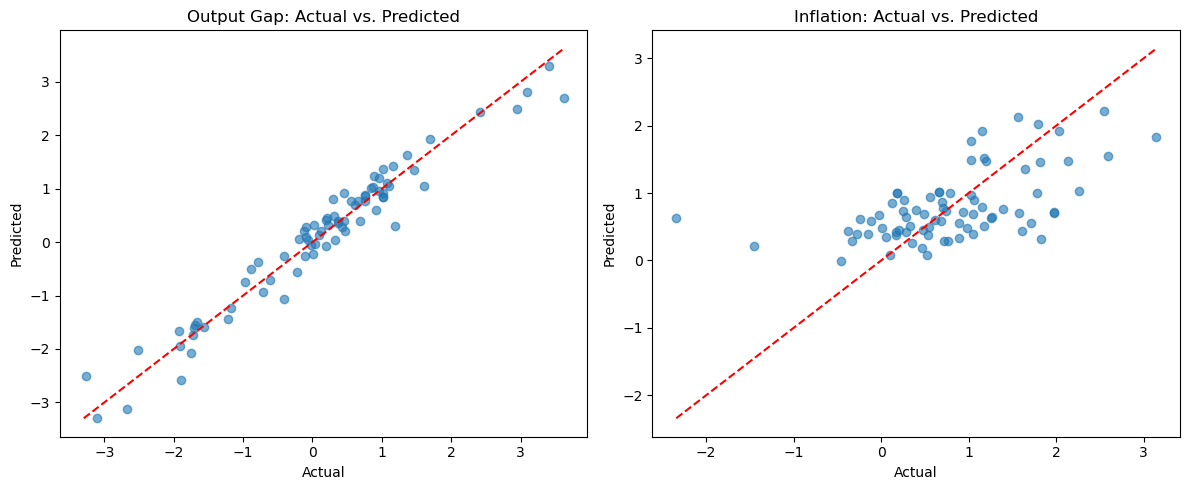

R2 for y:  0.9488067609493755 , R2 for pi:  0.3377694326952676


In [36]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import t as t_dist


# --------------------------------------------------
# 3. Extract Residuals (Reduced-Form)
# --------------------------------------------------
# Predicted values
y_y_pred = ols_model_y.predict(X_y)
y_pi_pred = ols_model_pi.predict(X_pi)

# Residuals
u_y = y_y - y_gap_pred
u_pi = y_pi - infl_pred

# --------------------------------------------------
# 4. Compute the Covariance of Reduced-Form Residuals
# --------------------------------------------------
# Stack the residuals: columns = [u_y, u_pi]
resid_matrix = np.column_stack([u_y, u_pi])
Sigma_u = np.cov(resid_matrix, rowvar=False)  # 2x2 matrix

# --------------------------------------------------
# 5. Cholesky Decomposition => Structural Identification
#    Sigma_u = P * P'  =>  structural shocks = P^(-1) * u
# --------------------------------------------------
P = np.linalg.cholesky(Sigma_u)
invP = np.linalg.inv(P)

# Structural shocks (shape: (T, 2))
e_struct = (invP @ resid_matrix.T).T

# --------------------------------------------------
# 6. Print or Inspect Results
# --------------------------------------------------
print("\n=== OLS Model for Output Gap (y_t) ===")
print("Coefficients:", ols_model_y.coef_)
print("Intercept:", ols_model_y.intercept_)

print("\n=== OLS Model for Inflation (pi_t) ===")
print("Coefficients:", ols_model_pi.coef_)
print("Intercept:", ols_model_pi.intercept_)

print("\n=== Reduced-Form Residual Covariance (Sigma_u) ===")
print(Sigma_u)

print("\n=== Cholesky Factor (P) ===")
print(P)

print("\n=== First 5 Structural Shocks (short-run ID) ===")
df_shocks = pd.DataFrame(e_struct[:5], columns=["shock_y", "shock_pi"])
print(df_shocks)

# --------------------------------------------------
# 7. Visualization: Actual vs. Predicted
# --------------------------------------------------

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Actual vs. Predicted (Output Gap)
ax[0].scatter(y_y, y_y_pred, alpha=0.6)
min_val = min(y_y.min(), y_y_pred.min())
max_val = max(y_y.max(), y_y_pred.max())
ax[0].plot([min_val, max_val], [min_val, max_val], 'r--')
ax[0].set_title('Output Gap: Actual vs. Predicted')
ax[0].set_xlabel('Actual')
ax[0].set_ylabel('Predicted')

# Plot 2: Actual vs. Predicted (Inflation)
ax[1].scatter(y_pi, y_pi_pred, alpha=0.6)
min_val = min(y_pi.min(), y_pi_pred.min())
max_val = max(y_pi.max(), y_pi_pred.max())
ax[1].plot([min_val, max_val], [min_val, max_val], 'r--')
ax[1].set_title('Inflation: Actual vs. Predicted')
ax[1].set_xlabel('Actual')
ax[1].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 8. R2 and p-values
# --------------------------------------------------
r2_y = r2_score(y_y, y_y_pred)
r2_pi = r2_score(y_pi, y_pi_pred)

print("R2 for y: ", r2_y, ", R2 for pi: ", r2_pi)

### b. with statsmodels

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. Prepare the Data
# --------------------------------------------------

# Example: Using the same columns as in your original code.
# Make sure `merged_df` is already loaded/cleaned.
X_y = merged_df[['Lag_y1', 'Lag_pi1', 'Lag_i1', 'Lag_i2']]
y_y = merged_df['Output_gap (%)']

X_pi = merged_df[['Output_gap (%)', 'Lag_y1', 'Lag_y2', 'Lag_pi1', 'Lag_pi2', 'Lag_i1']]
y_pi = merged_df['Inflation_Rate (%)']

# For statsmodels, we need to explicitly add a constant term to the predictors:
X_y_const = sm.add_constant(X_y)     # Adds intercept to X for output-gap model
X_pi_const = sm.add_constant(X_pi)   # Adds intercept to X for inflation model

# --------------------------------------------------
# 2. Fit Linear Models using statsmodels
# --------------------------------------------------

# Output Gap Model
ols_model_y = sm.OLS(y_y, X_y_const).fit()
print("=== Output Gap Model Summary ===")
print(ols_model_y.summary())

# Inflation Model
ols_model_pi = sm.OLS(y_pi, X_pi_const).fit()
print("\n=== Inflation Model Summary ===")
print(ols_model_pi.summary())


In [ ]:
# --------------------------------------------------
# 3. Visualization: Actual vs. Predicted
# --------------------------------------------------

# Predictions for the Output Gap Model
y_y_pred = ols_model_y.predict(X_y_const)

# Predictions for the Inflation Model
y_pi_pred = ols_model_pi.predict(X_pi_const)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: Actual vs. Predicted (Output Gap)
ax[0].scatter(y_y, y_y_pred, alpha=0.6)
# Plot a 45-degree reference line
min_val = min(y_y.min(), y_y_pred.min())
max_val = max(y_y.max(), y_y_pred.max())
ax[0].plot([min_val, max_val], [min_val, max_val], 'r--')
ax[0].set_title('Output Gap: Actual vs. Predicted')
ax[0].set_xlabel('Actual')
ax[0].set_ylabel('Predicted')

# --- Plot 2: Actual vs. Predicted (Inflation)
ax[1].scatter(y_pi, y_pi_pred, alpha=0.6)
min_val = min(y_pi.min(), y_pi_pred.min())
max_val = max(y_pi.max(), y_pi_pred.max())
ax[1].plot([min_val, max_val], [min_val, max_val], 'r--')
ax[1].set_title('Inflation: Actual vs. Predicted')
ax[1].set_xlabel('Actual')
ax[1].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 4. Table of Coefficients
# --------------------------------------------------

print("\n=== Output Gap Model Coefficients ===")
coef_y = pd.DataFrame({
    'Coefficient': ols_model_y.params,
    'p-value': ols_model_y.pvalues,
    '95% CI Lower': ols_model_y.conf_int()[0],
    '95% CI Upper': ols_model_y.conf_int()[1]
})
print(coef_y)

print("\n=== Inflation Model Coefficients ===")
coef_pi = pd.DataFrame({
    'Coefficient': ols_model_pi.params,
    'p-value': ols_model_pi.pvalues,
    '95% CI Lower': ols_model_pi.conf_int()[0],
    '95% CI Upper': ols_model_pi.conf_int()[1]
})
print(coef_pi)

# ANN

[ModelY] Early stopping at epoch 111
[ModelPi] Early stopping at epoch 113


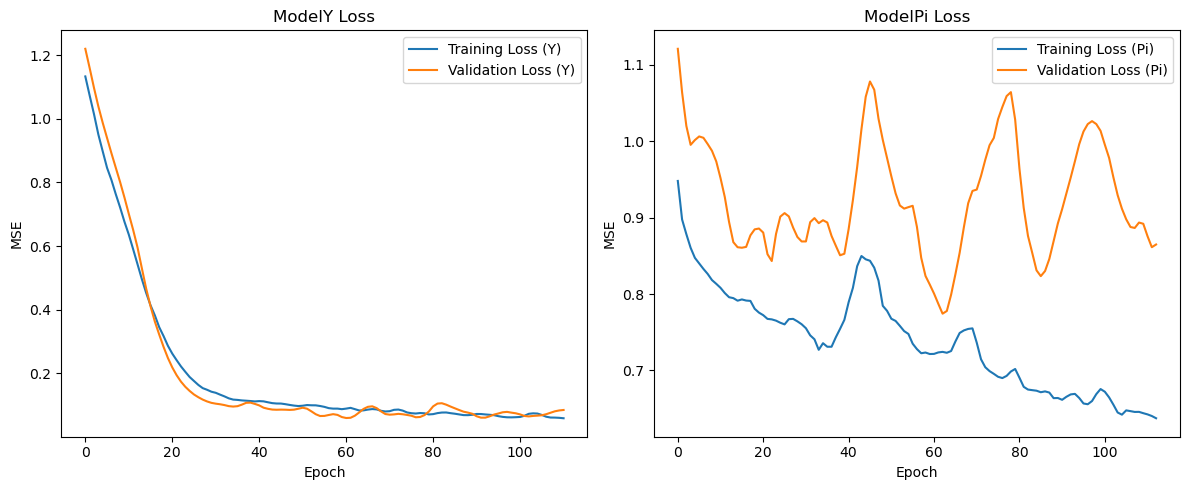

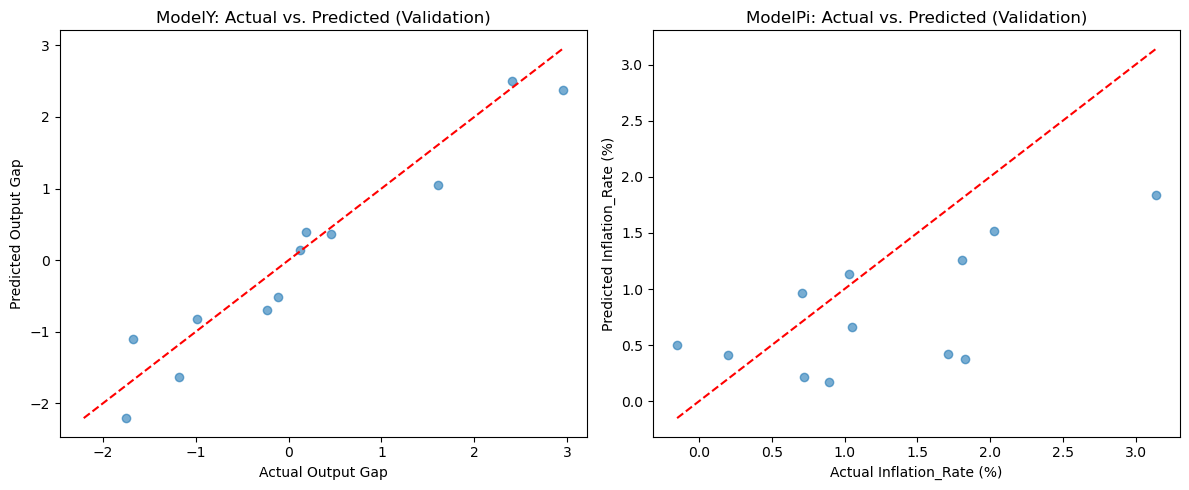


=== Sample Predictions ===
Y model predictions: [-0.70015866  2.3771038  -0.5109126  -2.204167   -1.628759  ]
Y actual values:     [-0.23  2.95 -0.11 -1.75 -1.18]
Pi model predictions: [0.3798653  1.133843   0.21886511 1.2581936  1.8367206 ]
Pi actual values:     [1.83 1.03 0.72 1.81 3.14]


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# --------------------------------------------------
# 1. Simple ANN block
# --------------------------------------------------
class ANN(nn.Module):
    """A simple feedforward ANN with 1 hidden layer."""
    def __init__(self, input_dim, hidden_dim):
        super(ANN, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.hidden(x))
        x = self.output(x)
        return x

# --------------------------------------------------
# 2. Model for predicting the output gap
# --------------------------------------------------
class ModelY:
    """
    Model for predicting the output gap, using an ANN internally.
    It includes StandardScalers for X (features) and y (target),
    so that predict() can handle unscaled data automatically.
    """
    def __init__(self, input_dim, hidden_dim=3, lr=0.01):
        self.model = ANN(input_dim, hidden_dim)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # Scalers for features and target
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

        self.train_losses = []
        self.val_losses = []
        self.fitted = False

    def fit(self, X_train, y_train, X_val, y_val, 
            max_epochs=1000, patience=10, batch_size=32):
        """
        Train the model using early stopping and mini-batch processing.
        This method fits scalers internally, so input (X_train, y_train) 
        should be unscaled data.
        
        :param X_train: Training features (numpy array, unscaled).
        :param y_train: Training targets (numpy array, unscaled).
        :param X_val: Validation features (numpy array, unscaled).
        :param y_val: Validation targets (numpy array, unscaled).
        :param max_epochs: Maximum number of training epochs.
        :param patience: Number of epochs to wait for improvement before stopping.
        :param batch_size: Size of each training batch.
        """
        # --------------------------------------------------
        # 2.1 Fit the scalers on the training data
        # --------------------------------------------------
        y_train = y_train.reshape(-1, 1)  # ensure 2D for scaler
        y_val = y_val.reshape(-1, 1)

        self.scaler_X.fit(X_train)
        self.scaler_y.fit(y_train)

        # Transform both training and validation data
        X_train_scaled = self.scaler_X.transform(X_train)
        y_train_scaled = self.scaler_y.transform(y_train)
        X_val_scaled   = self.scaler_X.transform(X_val)
        y_val_scaled   = self.scaler_y.transform(y_val)

        # Convert to PyTorch tensors
        X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1)
        X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
        y_val_t   = torch.tensor(y_val_scaled,   dtype=torch.float32).view(-1)

        # Create DataLoader for mini-batch training
        train_dataset = TensorDataset(X_train_t, y_train_t)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        best_val_loss = np.inf
        epochs_no_improve = 0
        best_state_dict = None

        for epoch in range(max_epochs):
            # ------------------------------
            # Training (Mini-Batch)
            # ------------------------------
            self.model.train()
            epoch_loss = 0.0
            for X_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                predictions = self.model(X_batch).squeeze()
                loss = self.criterion(predictions, y_batch)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() * X_batch.size(0)

            # Average training loss
            train_loss = epoch_loss / len(train_dataset)

            # ------------------------------
            # Validation
            # ------------------------------
            self.model.eval()
            with torch.no_grad():
                val_preds = self.model(X_val_t).squeeze()
                val_loss = self.criterion(val_preds, y_val_t).item()

            # Store losses for plotting
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            # ------------------------------
            # Early Stopping
            # ------------------------------
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state_dict = self.model.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"[ModelY] Early stopping at epoch {epoch+1}")
                break

        # Load the best model weights
        if best_state_dict is not None:
            self.model.load_state_dict(best_state_dict)

        self.fitted = True

    def predict(self, input_data):
        """
        Predict method that accepts unscaled NumPy data,
        scales it internally, and returns predictions in the original scale.
        
        :param input_data: A NumPy array of features (unscaled).
        :return: A NumPy array of predictions in original scale (unscaled).
        """
        if not self.fitted:
            raise RuntimeError("ModelY must be fitted before calling predict().")

        # Scale incoming features
        input_scaled = self.scaler_X.transform(input_data)

        self.model.eval()
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32)
        with torch.no_grad():
            preds_scaled = self.model(input_tensor).squeeze().numpy()

        # Inverse-transform the predictions back to original scale
        # Note: predictions are 1D, so reshape first
        preds_scaled_2D = preds_scaled.reshape(-1, 1)
        preds_unscaled = self.scaler_y.inverse_transform(preds_scaled_2D).ravel()
        return preds_unscaled

# --------------------------------------------------
# 3. Model for predicting inflation
# --------------------------------------------------
class ModelPi:
    """
    Model for predicting inflation (Inflation_Rate (%)), using an ANN internally.
    It includes StandardScalers for X (features) and y (target).
    """
    def __init__(self, input_dim, hidden_dim=4, lr=0.01):
        self.model = ANN(input_dim, hidden_dim)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # Scalers for features and target
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

        self.train_losses = []
        self.val_losses = []
        self.fitted = False

    def fit(self, X_train, y_train, X_val, y_val,
            max_epochs=1000, patience=10, batch_size=32):
        """
        Train the model using early stopping and mini-batch processing.
        This method fits scalers internally, so input (X_train, y_train)
        should be unscaled data.
        
        :param X_train: Training features (numpy array, unscaled).
        :param y_train: Training targets (numpy array, unscaled).
        :param X_val: Validation features (numpy array, unscaled).
        :param y_val: Validation targets (numpy array, unscaled).
        :param max_epochs: Maximum number of training epochs.
        :param patience: Number of epochs to wait for improvement before stopping.
        :param batch_size: Size of each training batch.
        """
        # --------------------------------------------------
        # 3.1 Fit the scalers on the training data
        # --------------------------------------------------
        y_train = y_train.reshape(-1, 1)  # ensure 2D for scaler
        y_val = y_val.reshape(-1, 1)

        self.scaler_X.fit(X_train)
        self.scaler_y.fit(y_train)

        # Transform both training and validation data
        X_train_scaled = self.scaler_X.transform(X_train)
        y_train_scaled = self.scaler_y.transform(y_train)
        X_val_scaled   = self.scaler_X.transform(X_val)
        y_val_scaled   = self.scaler_y.transform(y_val)

        # Convert to PyTorch tensors
        X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1)
        X_val_t   = torch.tensor(X_val_scaled,   dtype=torch.float32)
        y_val_t   = torch.tensor(y_val_scaled,   dtype=torch.float32).view(-1)

        # Create DataLoader for mini-batch training
        train_dataset = TensorDataset(X_train_t, y_train_t)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        best_val_loss = np.inf
        epochs_no_improve = 0
        best_state_dict = None

        for epoch in range(max_epochs):
            # ------------------------------
            # Training (Mini-Batch)
            # ------------------------------
            self.model.train()
            epoch_loss = 0.0
            for X_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                predictions = self.model(X_batch).squeeze()
                loss = self.criterion(predictions, y_batch)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() * X_batch.size(0)

            # Average training loss
            train_loss = epoch_loss / len(train_dataset)

            # ------------------------------
            # Validation
            # ------------------------------
            self.model.eval()
            with torch.no_grad():
                val_preds = self.model(X_val_t).squeeze()
                val_loss = self.criterion(val_preds, y_val_t).item()

            # Store losses for plotting
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            # ------------------------------
            # Early Stopping
            # ------------------------------
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state_dict = self.model.state_dict()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"[ModelPi] Early stopping at epoch {epoch+1}")
                break

        # Load the best model weights
        if best_state_dict is not None:
            self.model.load_state_dict(best_state_dict)

        self.fitted = True

    def predict(self, input_data):
        """
        Predict method that accepts unscaled NumPy data,
        scales it internally, and returns predictions in the original scale.
        
        :param input_data: A NumPy array of features (unscaled).
        :return: A NumPy array of predictions in original scale (unscaled).
        """
        if not self.fitted:
            raise RuntimeError("ModelPi must be fitted before calling predict().")

        # Scale incoming features
        input_scaled = self.scaler_X.transform(input_data)

        self.model.eval()
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32)
        with torch.no_grad():
            preds_scaled = self.model(input_tensor).squeeze().numpy()

        # Inverse-transform predictions
        preds_scaled_2D = preds_scaled.reshape(-1, 1)
        preds_unscaled = self.scaler_y.inverse_transform(preds_scaled_2D).ravel()
        return preds_unscaled

# --------------------------------------------------
# 4. Example usage (main)
# --------------------------------------------------
if __name__ == "__main__":
    # Suppose you have merged_df with the following columns:
    #   'Lag_y1', 'Lag_pi1', 'Lag_i1', 'Lag_i2', 'Output_gap (%)', 
    #   'Lag_y2', 'Lag_pi2', 'Inflation_Rate (%)'
    
    # 4.1 Prepare input/output data
    X_y = merged_df[['Lag_y1', 'Lag_pi1', 'Lag_i1', 'Lag_i2']].values
    y_y = merged_df['Output_gap (%)'].values  # shape (n_samples,)

    X_pi = merged_df[['Output_gap (%)', 'Lag_y1', 'Lag_y2', 'Lag_pi1', 'Lag_pi2', 'Lag_i1']].values
    y_pi = merged_df['Inflation_Rate (%)'].values  # shape (n_samples,)

    # 4.2 Train-Val Split (Unscaled data)
    X_y_train, X_y_val, y_y_train, y_y_val = train_test_split(
        X_y, y_y, test_size=0.15, random_state=42
    )
    X_pi_train, X_pi_val, y_pi_train, y_pi_val = train_test_split(
        X_pi, y_pi, test_size=0.15, random_state=42
    )

    # 4.3 Initialize Models
    ann_model_y = ModelY(input_dim=X_y.shape[1], hidden_dim=3, lr=0.01)
    ann_model_pi = ModelPi(input_dim=X_pi.shape[1], hidden_dim=4, lr=0.01)

    # 4.4 Train with early stopping and mini-batch
    #     Notice we pass the unscaled data, and the model does the scaling inside fit().
    ann_model_y.fit(X_y_train, y_y_train, X_y_val, y_y_val,
                max_epochs=1000, patience=50, batch_size=32)
    ann_model_pi.fit(X_pi_train, y_pi_train, X_pi_val, y_pi_val,
                 max_epochs=1000, patience=50, batch_size=32)

    # 4.5 Plot training and validation losses
    plt.figure(figsize=(12, 5))

    # -- ModelY Loss
    plt.subplot(1, 2, 1)
    plt.plot(ann_model_y.train_losses, label='Training Loss (Y)')
    plt.plot(ann_model_y.val_losses, label='Validation Loss (Y)')
    plt.title('ModelY Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    # -- ModelPi Loss
    plt.subplot(1, 2, 2)
    plt.plot(ann_model_pi.train_losses, label='Training Loss (Pi)')
    plt.plot(ann_model_pi.val_losses, label='Validation Loss (Pi)')
    plt.title('ModelPi Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 4.6 Predictions (on validation set) - pass X_val unscaled
    y_val_preds = ann_model_y.predict(X_y_val)
    pi_val_preds = ann_model_pi.predict(X_pi_val)

    # 4.7 Compare predictions to actual values
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # --- Output Gap (ModelY) ---
    ax[0].scatter(y_y_val, y_val_preds, alpha=0.6)
    min_val = min(y_y_val.min(), y_val_preds.min())
    max_val = max(y_y_val.max(), y_val_preds.max())
    ax[0].plot([min_val, max_val], [min_val, max_val], 'r--')
    ax[0].set_title('ModelY: Actual vs. Predicted (Validation)')
    ax[0].set_xlabel('Actual Output Gap')
    ax[0].set_ylabel('Predicted Output Gap')

    # --- Inflation (ModelPi) ---
    ax[1].scatter(y_pi_val, pi_val_preds, alpha=0.6)
    min_val = min(y_pi_val.min(), pi_val_preds.min())
    max_val = max(y_pi_val.max(), pi_val_preds.max())
    ax[1].plot([min_val, max_val], [min_val, max_val], 'r--')
    ax[1].set_title('ModelPi: Actual vs. Predicted (Validation)')
    ax[1].set_xlabel('Actual Inflation_Rate (%)')
    ax[1].set_ylabel('Predicted Inflation_Rate (%)')

    plt.tight_layout()
    plt.show()

    # 4.8 Print some example predictions (unscaled input -> unscaled output)
    print("\n=== Sample Predictions ===")
    print("Y model predictions:", y_val_preds[:5])
    print("Y actual values:    ", y_y_val[:5])

    print("Pi model predictions:", pi_val_preds[:5])
    print("Pi actual values:    ", y_pi_val[:5])


# Environment

In [13]:
Env_df = merged_df[['Inflation_Rate (%)','Avg_Interest_Rate','Output_gap (%)']]
Env_df

,Inflation_Rate (%),Avg_Interest_Rate,Output_gap (%)
2,1.03,8.630,2.95
3,1.98,8.080,3.62
4,1.78,10.755,3.41
5,2.14,12.880,3.10
6,2.03,12.880,2.41
...,...,...,...
75,1.26,4.500,-0.09
76,0.76,4.750,-0.02
77,0.01,5.000,-0.07
78,0.17,5.250,0.33


In [14]:
import gymnasium as gym
import numpy as np
import pandas as pd
from gymnasium.spaces import Box

class PaperBasedEconomyEnv(gym.Env):
    def __init__(
        self,
        model_y,            # e.g. a LinearRegression() for Output Gap
        model_pi,           # e.g. a LinearRegression() for Inflation
        historical_df,      # historical data for reset()
        lookback_periods=2,
        inflation_target=2.0,
        output_gap_target=0.0,
        max_steps=50,
        

    ):
        super(PaperBasedEconomyEnv, self).__init__()

        # Store initial DataFrame and reset index
        self.model_y = model_y       # The trained model for predicting Output Gap
        self.model_pi = model_pi     # The trained model for predicting Inflation
        self.lookback_periods = lookback_periods
        self.inflation_target = inflation_target
        self.output_gap_target = output_gap_target
        self.historical_df = historical_df
        self.df = historical_df.iloc[0:3].copy()
        self.max_steps = max_steps  # number of timesteps per episode

        # Column references for readability
        self.cols = {
            'inflation': 'Inflation_Rate (%)',
            'output_gap': 'Output_gap (%)',
            'interest_rate': 'Avg_Interest_Rate'
        }

        # Action space: choose the next interest rate
        self.action_space = Box(low=-20.0, high= 20.0, shape=(1,), dtype=np.float32)

        # Observation space: for each of the last N periods, we store
        # [inflation, output_gap, interest_rate], plus 1 extra for interest_rate(t-1)
        obs_space_size = 3 * self.lookback_periods# + 1
        self.observation_space = Box(
            low=-np.inf, high=np.inf, shape=(obs_space_size,), dtype=np.float32
        )

        self.current_idx = self.lookback_periods
        self.done = False

    def reset(self, seed=None, options=None):
        """
        Reset the environment:
          1. Choose a random start index that allows for the lookback period.
          2. Initialize self.df with 3 consecutive rows starting from the random index.
          3. Reset step counters and done flag.
          4. Return the initial observation.
        """
        super().reset(seed=seed)

        # Calculate the maximum possible starting index
        required_rows = self.lookback_periods + 1  # 2 lookbacks + 1 current step = 3 rows
        max_start = len(self.historical_df) - required_rows

        if max_start <= 0:
            raise ValueError(
                "DataFrame is too small for the given lookback_periods. "
                "Reduce lookback_periods or provide more data."
            )

        # Randomly select a starting index
        random_start_index = self.np_random.integers(low=0, high=max_start + 1)

        # Initialize self.df with 3 consecutive rows from the original DataFrame
        self.df = self.historical_df.iloc[random_start_index:random_start_index + required_rows].reset_index(drop=True).copy()

        # Set current_idx to point to the last row in the initial df
        self.current_idx = self.lookback_periods  # Zero-based indexing

        # Reset step counters and done flag
        self.episode_step = 0
        self.done = False

        # Get the initial observation
        obs = self._get_state()
        info = {}
        return obs, info


    def step(self, action):
        """
        1. Parse the current state
        2. Construct the feature vectors for each model
        3. Predict next_output_gap and next_inflation
        4. Compute reward
        5. Append new row to DataFrame
        6. Advance time index
        7. Return (state, reward, done, info)
        """
        if self.done:
            raise RuntimeError("Environment is done. Call reset().")
        
        self.episode_step += 1

        # Action is the chosen interest rate for this step
        interest_rate = float(action[0])
        # Current state (shape: (3*lookback_periods + 1,))
        state = self._get_state()

        # ---------------------------------------------------------
        # 1) Parse the state for clarity
        #    Example for lookback=2:
        #    state = [
        #        inflation(t-2), interest_rate(t-2), output_gap(t-2)
        #        inflation(t-1), interest_rate(t-1), output_gap(t-1)
        #    ]
        # ---------------------------------------------------------
        # Let's label them (assuming lookback_periods=2)
        inflation_t2        = state[0]      # inflation(t-2)
        interest_rate_t2    = state[1]  # interest_rate(t-2)
        output_gap_t2       = state[2]     # output_gap(t-2)
        inflation_t1        = state[3]      # inflation(t-1)
        interest_rate_t1    = state[4]  # interest_rate(t-1)
        output_gap_t1       = state[5]     # output_gap(t-1)
        # state[6] is interest_rate(t-1) repeated in your original code
        # (You might want to adjust that logic—see explanation below.)

        # ---------------------------------------------------------
        # 2) Construct model_y features
        #    Based on how model_y was trained:
        #        X_y columns = ['Lag_y1', 'Lag_pi1', 'Lag_i1', 'Lag_i2']
        #
        #    This implies:
        #       Lag_y1 = output_gap(t-1)
        #       Lag_pi1 = inflation(t-1)
        #       Lag_i1 = interest_rate(t-1)
        #       Lag_i2 = interest_rate(t-2)
        # ---------------------------------------------------------
        features_y = pd.DataFrame({
            'Lag_y1': [output_gap_t1],
            'Lag_pi1': [inflation_t1],
            'Lag_i1': [interest_rate_t1],
            'Lag_i2': [interest_rate_t2]
        })

        # Predict the next output gap
        next_output_gap = self.model_y.predict(features_y)[0]

        # ---------------------------------------------------------
        # 3) Construct model_pi features
        #    Based on how model_pi was trained:
        #        X_pi columns = [
        #           'Output_gap (%)',
        #           'Lag_y1', 'Lag_y2',
        #           'Lag_pi1', 'Lag_pi2',
        #           'Lag_i1'
        #        ]
        #
        #    This implies:
        #       'Output_gap (%)' = *current* output gap used for next inflation
        #       Lag_y1 = output_gap(t-1)
        #       Lag_y2 = output_gap(t-2)
        #       Lag_pi1 = inflation(t-1)
        #       Lag_pi2 = inflation(t-2)
        #       Lag_i1 = interest_rate(t-1)
        #
        #    Here, we have a choice to use the brand-new next_output_gap or
        #    the last known output_gap(t-1). In some setups, we feed the
        #    newly predicted output_gap back in. That is an economic modeling
        #    choice—just be consistent with your original training approach.
        # ---------------------------------------------------------
        features_pi = pd.DataFrame({
            'Output_gap (%)': [next_output_gap],  # or output_gap_t1 if you prefer
            'Lag_y1': [output_gap_t1],
            'Lag_y2': [output_gap_t2],
            'Lag_pi1': [inflation_t1],
            'Lag_pi2': [inflation_t2],
            'Lag_i1': [interest_rate_t1]
        })

        # Predict the next inflation
        next_inflation = self.model_pi.predict(features_pi)[0]

        # ---------------------------------------------------------
        # 4) Compute reward
        #    Negative MSE-like penalty from inflation & output gap deviation
        # ---------------------------------------------------------
        reward = -(
            0.5 * (next_inflation - self.inflation_target) ** 2
            + 0.5 * (next_output_gap - self.output_gap_target) ** 2
        )

        # ---------------------------------------------------------
        # 5) Append new row to the DataFrame
        # ---------------------------------------------------------
        new_row = {
            self.cols['inflation']: next_inflation,
            self.cols['output_gap']: next_output_gap,
            self.cols['interest_rate']: interest_rate
        }
        # NOTE: .append() is deprecated in recent Pandas; here’s one alternative:

        self.df = pd.concat([self.df, pd.DataFrame([new_row])], ignore_index=True)

        # ---------------------------------------------------------
        # 6) Advance time index and check termination
        # ---------------------------------------------------------
        self.current_idx += 1

        if self.episode_step >= self.max_steps:
            self.done = True

        # 7) Return the new state, reward, done, truncated, info
        
        truncated = False

        return self._get_state(), reward, self.done, truncated, {}

    def _get_state(self):
        """
        Builds an array of shape (3*lookback_periods + 1,).
        For lookback=2, we collect:
          [inflation(t-2), rate(t-2), gap(t-2), inflation(t-1), rate(t-1), gap(t-1)]
        """
        # Retrieve the current row and the previous row
        row_t_minus_1 = self.df.iloc[self.current_idx]
        row_t_minus_2 = self.df.iloc[self.current_idx - 1]

        # Convert both rows to lists
        current_row_list = row_t_minus_1.tolist()
        previous_row_list = row_t_minus_2.tolist()

        # Combine the two lists
        state = previous_row_list + current_row_list

        return np.array(state, dtype=np.float32)

# ----------------------------
# Example usage
# ----------------------------
if __name__ == "__main__":

    # Suppose model_y and model_pi are scikit-learn models, e.g.:
    # model_y = LinearRegression().fit(X_y, y_y)
    # model_pi = LinearRegression().fit(X_pi, y_pi)
    #
    # Or if you're returning functions (predict_y, predict_pi) from linear_model(),
    # you can wrap them in small classes that define a .predict() method.
    # For demonstration, let's assume they are already fitted regressions.
    class MockModel:
        def predict(self, X):
            # Some dummy logic; in reality, this would be your real model
            return np.ones(shape=(X.shape[0],)) * 0.3


    mock_model_y = MockModel()
    mock_model_pi = MockModel()

    env = PaperBasedEconomyEnv( historical_df = Env_df,
                                model_y = mock_model_y,
                                model_pi = mock_model_pi, 
                                lookback_periods = 2)
    state = env.reset()

    for step_i in range(10):
        action = env.action_space.sample()  # Random interest rate
        state, reward, done, truncated, info = env.step(action)
        #print(f"Step={step_i}, State={state}, Reward={reward}, Truncated={truncated}, Done={done}")
        if done:
            break


In [15]:
env = PaperBasedEconomyEnv(
    historical_df=Env_df,
    model_y= ann_model_y,
    model_pi= ann_model_pi,
    lookback_periods=2,
    inflation_target=2.0,
    output_gap_target=0.0,
    max_steps=50  # Force each episode to be 50 steps
)

# We’ll do a short test episode
obs, info = env.reset()
total_reward = 0
for step_i in range(60):  # We only expect max 50 steps
    action = env.action_space.sample()  # random interest rate
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward
    if done:
        print(f"Episode finished after {step_i+1} steps. Total reward = {total_reward:.2f}")
        break

# Reset again and start from a different random point
obs, info = env.reset()
print("Second episode starts from a different random index...")    

C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\

Episode finished after 50 steps. Total reward = -128.77
Second episode starts from a different random index...


C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [16]:
env.reset()
print(env.df)

   Inflation_Rate (%)  Avg_Interest_Rate  Output_gap (%)
0                1.05               5.38           -1.57
1                0.47               5.13           -1.22
2               -0.46               5.13           -0.41


In [17]:

action = [0]
state, reward, done, truncated, info = env.step(action)
print("State: ", state)
print(f"Action: {action}, Reward: {reward}, Done: {done}")
print(env.df)




State:  [-0.46        5.13       -0.41        0.30283448  0.         -0.14505182]
Action: [0], Reward: -1.4507054149821195, Done: False
   Inflation_Rate (%)  Avg_Interest_Rate  Output_gap (%)
0            1.050000               5.38       -1.570000
1            0.470000               5.13       -1.220000
2           -0.460000               5.13       -0.410000
3            0.302834               0.00       -0.145052


C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


# Train

In [18]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

env = PaperBasedEconomyEnv(
        historical_df=Env_df,
        model_y=ann_model_y,
        model_pi=ann_model_pi,
        lookback_periods=2,
        inflation_target=2.0,
        output_gap_target=0.0,
        max_steps=50  # Force each episode to be 50 steps
    )

log_dir = "./logs/"
env = Monitor(env, filename=log_dir)

In [19]:
venv = DummyVecEnv([lambda: env])  # wrap your environment

model = PPO(
    policy="MlpPolicy",
    env=venv,
    verbose=1,
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # You can tune many hyperparameters here
)
model.learn(total_timesteps=1_000)


Using cpu device


C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -111     |
| time/              |          |
|    fps             | 93       |
|    iterations      | 1        |
|    time_elapsed    | 21       |
|    total_timesteps | 2048     |
---------------------------------


C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Reset the environment
obs = venv.reset()

# This list will hold (step, action, reward, observation)
step_log = []


for i in range(10):
    # Use the trained model to predict an action
    action, _ = model.predict(obs)
    # Take a step in the environment
    obs, rewards, dones, infos = venv.step(action)

    # For a single-environment VecEnv, obs has shape (1, obs_dim),
    # action has shape (1, action_dim), and rewards/dones are length-1 arrays.
    # We'll store the *first* environment's values.
    print(obs)
    print(f"Step: {i}, Action: {action}, Reward: {rewards}, Done: {dones}")

    # Convert to float to avoid arrays in the log
    step_idx = i
    act_value = float(action[0][0])  # if your action shape is (1, 1)
    reward_value = float(rewards[0])

    # obs[0] is the actual observation array for the first (and only) env
    # We'll store a copy so it doesn't get overwritten next iteration
    observation_array = obs[0].copy()

    step_log.append((step_idx, act_value, reward_value, observation_array))

    # If done, reset the environment
    if dones[0]:
        obs = venv.reset()




C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\

[[-0.46        5.13       -0.41        0.30283448 -0.37368965 -0.14505182]]
Step: 0, Action: [[-0.37368965]], Reward: [-1.4507054], Done: [False]
[[ 0.30283448 -0.37368965 -0.14505182 -0.2636663   0.24136418  0.19082317]]
Step: 1, Action: [[0.24136418]], Reward: [-2.5802994], Done: [False]
[[-0.2636663   0.24136418  0.19082317 -0.14169829 -0.6521895   0.34622586]]
Step: 2, Action: [[-0.6521895]], Reward: [-2.3533719], Done: [False]
[[-0.14169829 -0.6521895   0.34622586 -0.07658694  0.27959415  0.5170174 ]]
Step: 3, Action: [[0.27959415]], Reward: [-2.28976], Done: [False]
[[-0.07658694  0.27959415  0.5170174   0.0429829  -0.34269497  0.56436414]]
Step: 4, Action: [[-0.34269497]], Reward: [-2.0742114], Done: [False]
[[ 0.0429829  -0.34269497  0.56436414 -0.00174151  0.89514947  0.65984654]]
Step: 5, Action: [[0.89514947]], Reward: [-2.2211833], Done: [False]
[[-0.00174151  0.89514947  0.65984654  0.13016893  0.352436    0.66486216]]
Step: 6, Action: [[0.352436]], Reward: [-1.969155], Do

C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\angel\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


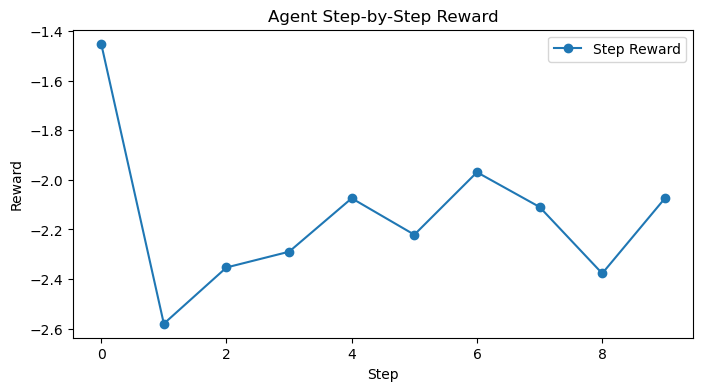

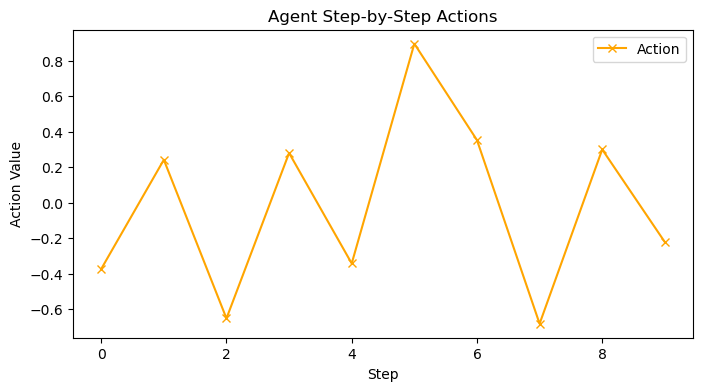

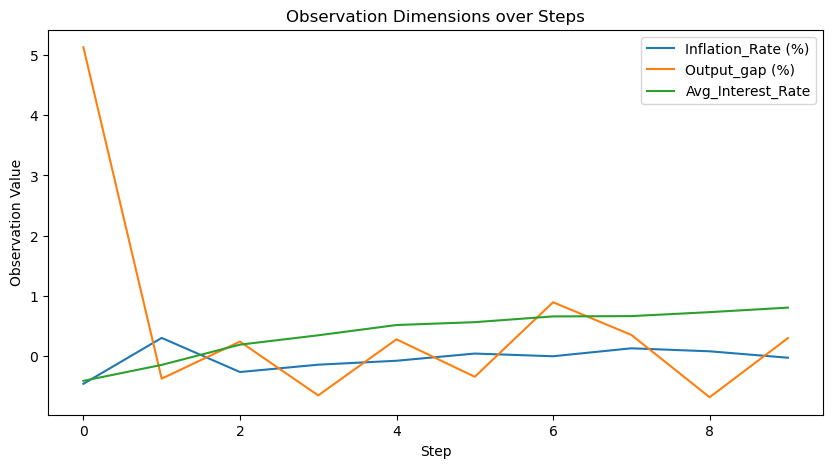

In [21]:
col_names = [
    'Inflation_Rate (%)',
    'Output_gap (%)',
    'Avg_Interest_Rate'
]

# -------------------------------------------------
# Convert the logged data into NumPy arrays for plotting
# -------------------------------------------------
steps = np.array([x[0] for x in step_log])
actions = np.array([x[1] for x in step_log])
step_rewards = np.array([x[2] for x in step_log])
observations = np.array([x[3] for x in step_log])  # shape: (num_steps, obs_dim)

# -------------------------------------------------
# 1) Plot the step-by-step rewards
# -------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(steps, step_rewards, marker='o', label='Step Reward')
plt.title("Agent Step-by-Step Reward")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.legend()
plt.show()

# -------------------------------------------------
# 2) Plot the step-by-step actions
# -------------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(steps, actions, marker='x', color='orange', label='Action')
plt.title("Agent Step-by-Step Actions")
plt.xlabel("Step")
plt.ylabel("Action Value")
plt.legend()
plt.show()

# -------------------------------------------------
# 3) Plot the observations (each dimension separately)
# -------------------------------------------------
obs_dim = observations.shape[1]  # how many features per observation
plt.figure(figsize=(10, 5))
for dim in range(3):
    plt.plot(steps, observations[:, dim], label= col_names[dim])

plt.title("Observation Dimensions over Steps")
plt.xlabel("Step")
plt.ylabel("Observation Value")
plt.legend()
plt.show()